In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [4]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50.json')
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'sentences', 'type',
        'urls'],
       dtype='object'))

In [5]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [6]:
0.8*475

380.0

In [7]:
titles = sorted(df_hd_tp_cdc.Title.unique())
non_test_titles = list(set(titles)-set(test_titles))
val_titles = non_test_titles[380:]
train_titles = titles[:380]
len(train_titles),len(val_titles),len(test_titles)

(380, 95, 47)

In [8]:
train_batchsize = 32
val_batchsize = 32
test_batchsize = 8
train_steps_per_epoch = 4
val_steps_per_epoch = 1
test_steps = 10
epochs = 1000

In [9]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [10]:
def datagen_cdc(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds, ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        hd = dataframe[dataframe.Title==idx]['Headline'].values[0].lower()
        hds.append(hd)
        ar_id = dataframe[dataframe.Title==idx]['article Id'].values[0]
        cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
        ar_claims.append(cl)
        sentences=articles[ar_id]
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
            
def datagen_dnf(batchsize,dataframe):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        idx=np.random.choice(dataframe.id.nunique())
        hd = dataframe[dataframe.id==idx]['headline'].values[0]
        ar_id = dataframe[dataframe.id==idx]['id'].values[0]
        cl = dataframe[dataframe.id==idx]['sentences'].values[0]
        hds.append(hd)
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
        with open('evaluation_set/deepnofakes/cleaned/article_{0}.txt'.format(ar_id)) as f:
            article = f.readlines()
            
        article=''.join(article)
        # print(article)
        article = article.replace('[REF]','')
        doc = sentencizer(article)
        sentences = [sent.string.strip() for sent in doc.sents]
    
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = []
        for s in sentences:
            vectors.append(nlp(s.lower()).vector)
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
            counter=0
            

In [11]:
tdg = datagen_cdc(train_batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(val_batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_cdc(test_batchsize,df_hd_tp_cdc,mode='test')

In [12]:
# x,y = next(test_dg)

In [13]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

s.shape: (?, 1, 1300)
beta.shape: [None, 1, 1300]
s.shape: (?, 1, 1300)
beta.shape: [None, 1, 1300]
s.shape: (?, 1, 1300)
beta.shape: [None, 1, 1300]
s.shape: (?, 1, 1300)
beta.shape: [None, 1, 1300]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 1300, 300)    0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 1300, 16)     14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 1300, 16)     0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9

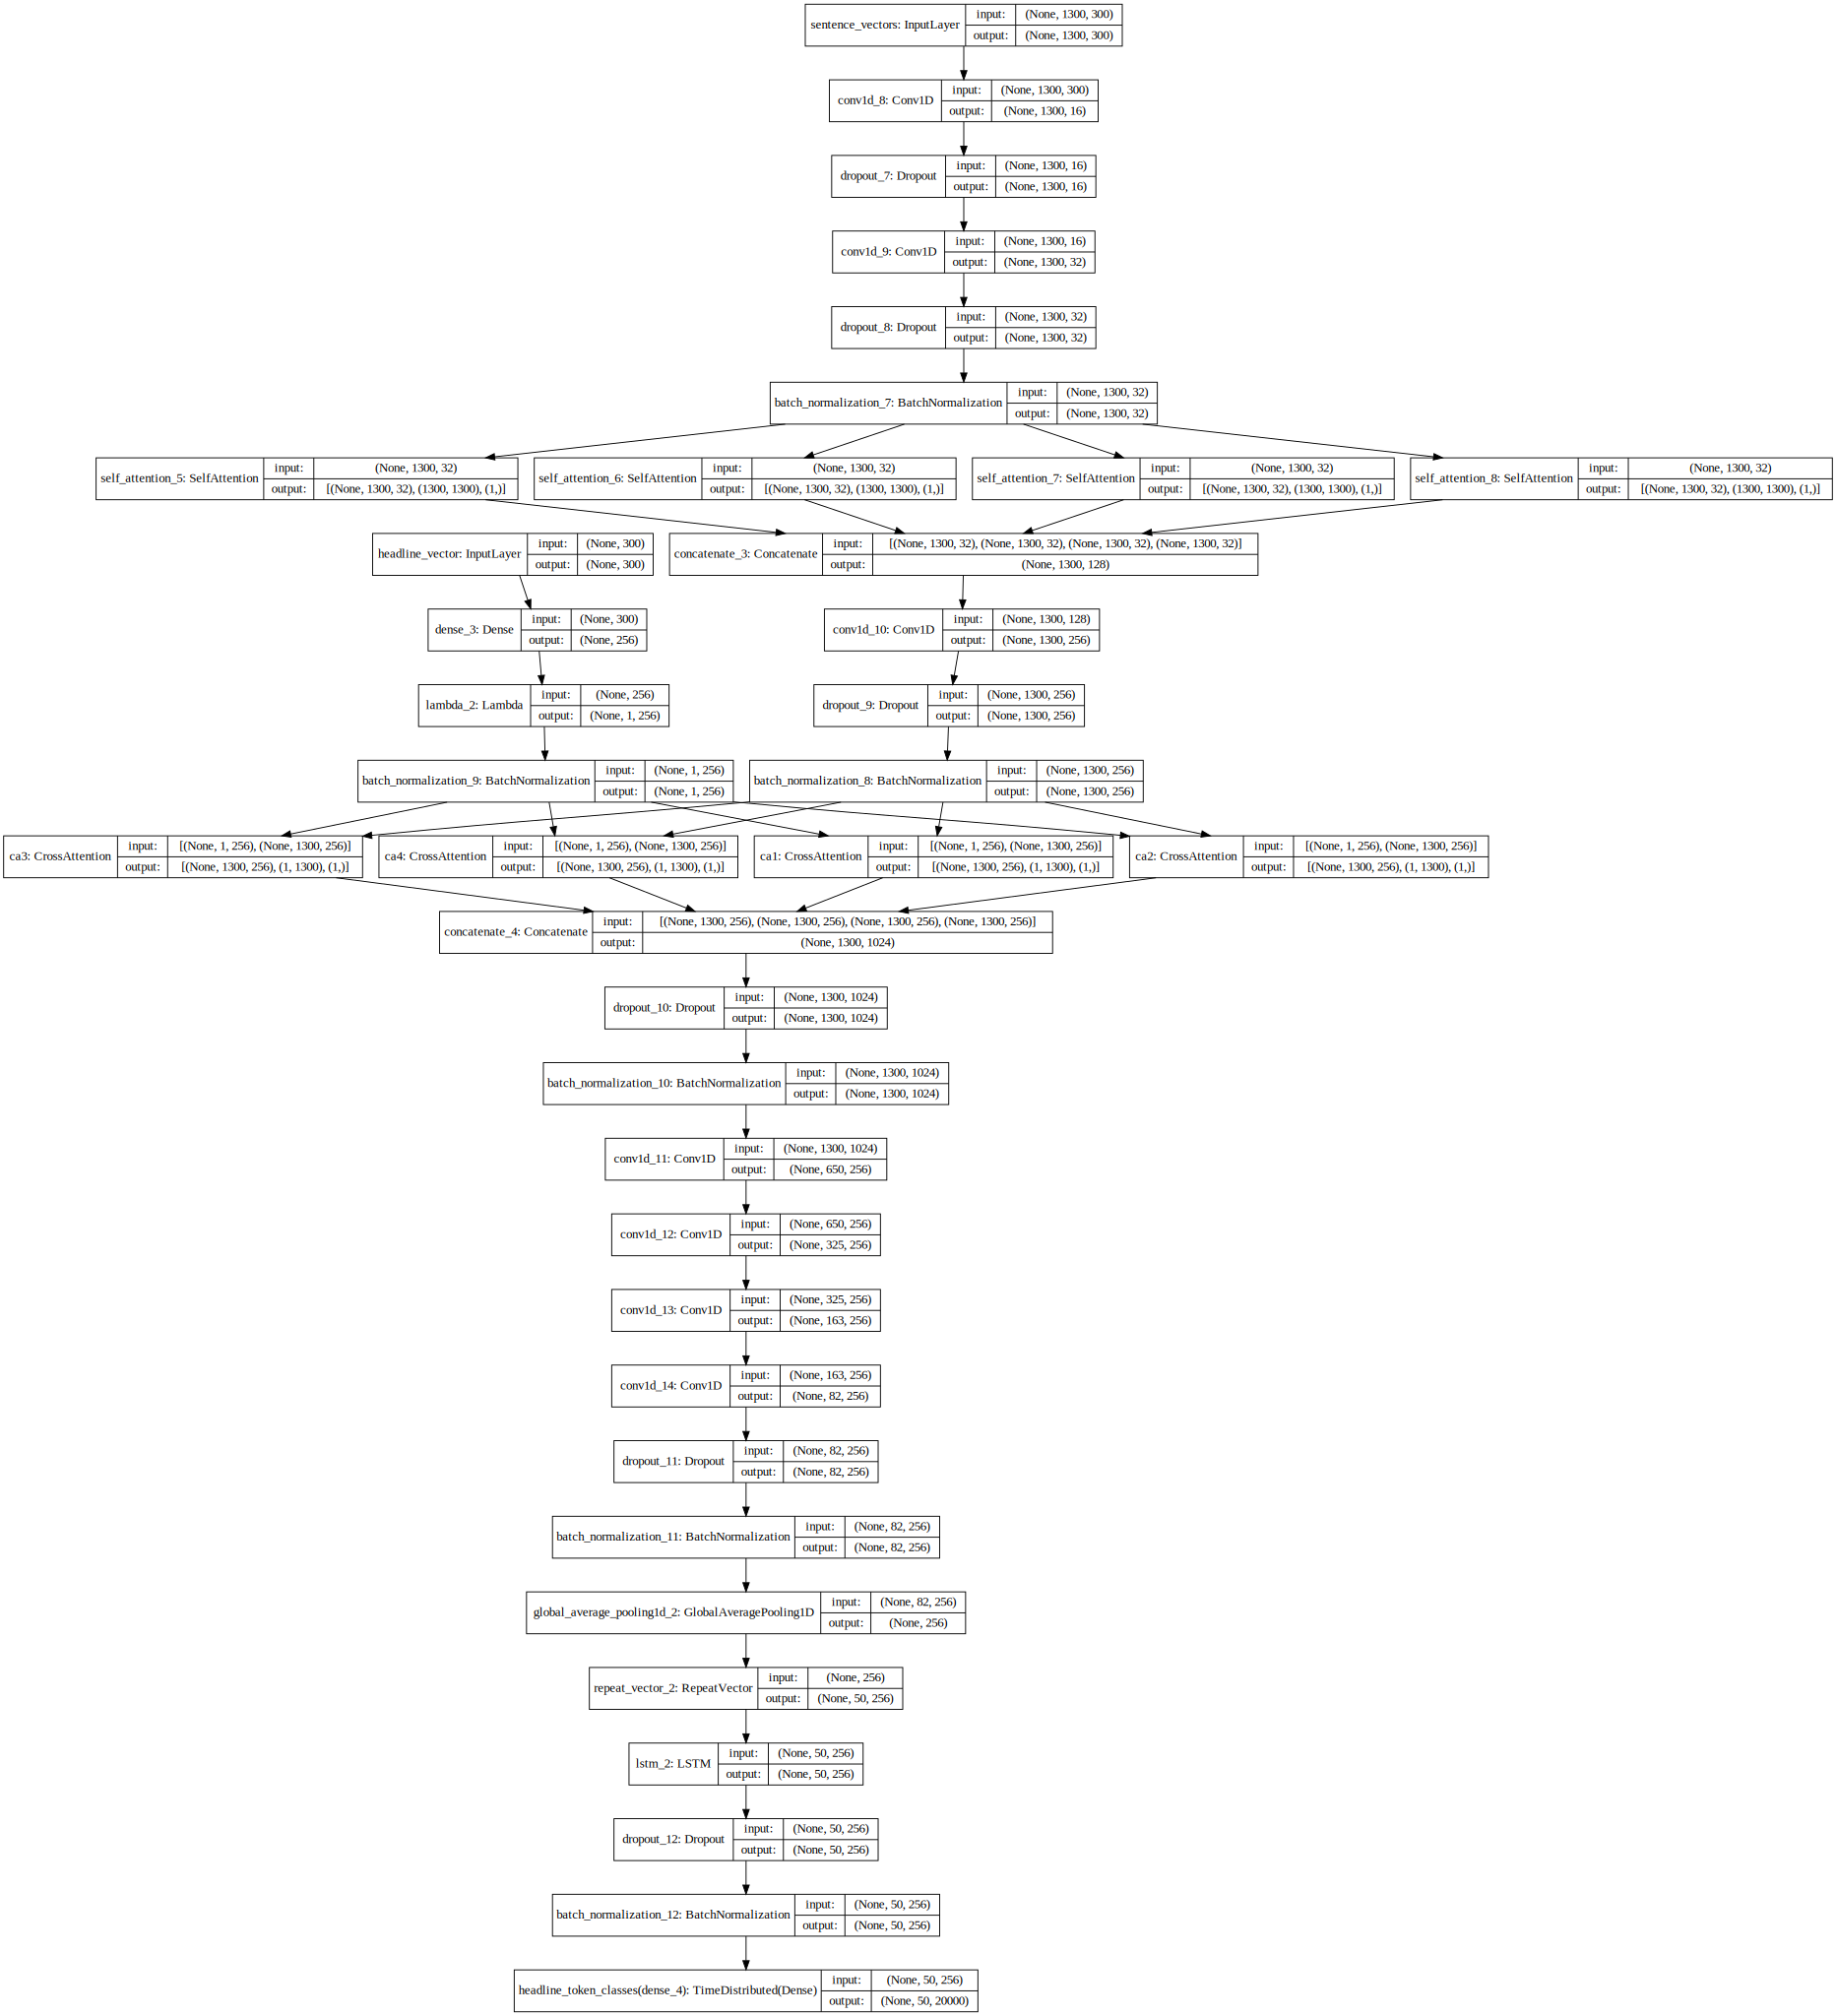

In [50]:
def build_model():
    inp_sentence_vectors = Input(shape=(1300, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]))(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_vector = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [15]:
# dt = datetime.now()
# mc = ModelCheckpoint('weights/cdc_sa_sent_hd_word.hdf5',save_best_only=True,save_weights_only=True)
# tb = TensorBoard(batch_size=32,log_dir='logs/cdc_sa_sent_hd_word/{0}'.format(dt.timestamp()),write_graph=True)

In [16]:
# hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=1000
#                            ,steps_per_epoch=train_steps_per_epoch
#                            ,validation_data=vdg
#                            ,validation_steps=val_steps_per_epoch
#                            ,epochs=epochs+9000)

In [17]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [18]:
# df_res = pd.DataFrame(hist.history)

In [19]:
# df_res[['loss','val_loss']].plot()

In [20]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [21]:
x,y = next(test_dg)
x

{'article_id': array([2225, 2190,  205, 2190,  236,  203, 2245, 2555]),
 'claims': array([array(['arguments for the existence of God show insufficient reason to believe',
        'the universe includes "ideas" not perceptible to mankind (or not always perceptible), and that there must therefore exist an omniscient superobserver',
        'there was a "first cause", or "prime mover" who is identified as God',
        "the universe's order and complexity are best explained by reference to a creator God",
        'certain features of the universe and of living things are the product of an intelligent cause',
        "basic facts, such as humanity's existence, are best explained by the existence of God",
        'ethics, and other serious matters do not make sense in the absence of God',
        'atheistic arguments must ultimately refute themselves if pressed with rigorous consistency',
        "the theism of people throughout most of recorded history and in many different places provides

In [51]:
model.load_weights('weights/cdc_sa_sent_hd_word.hdf5')
model.evaluate_generator(test_dg,steps=test_steps)

[0.8638285279273987, 0.8549999892711639]

In [52]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 1300, 300)    0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 1300, 16)     14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 1300, 16)     0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 1300, 32)     1568        dropout_7[0][0]                  
__________________________________________________________________________________________________
dropout_8 

In [67]:
test_idx = 0
_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [68]:
b = b1+b2+b3+b4

In [69]:
best_N = 5
t = b[test_idx][0].argsort()[-best_N:][::-1]
t

array([ 15, 114, 137, 268, 138])

In [70]:
print(len(x['sentences'][test_idx]))
b1[test_idx][0][:len(x['sentences'][test_idx])].sum()

279


869.2595

In [71]:
# t = []
# t.append(np.argmax(b1[test_idx][0]))
# t.append(np.argmax(b2[test_idx][0]))
# t.append(np.argmax(b3[test_idx][0]))
# t.append(np.argmax(b4[test_idx][0]))
# t

In [72]:
x['headline'][test_idx]

'atheism is the only way'

In [73]:
x['claims'][test_idx]

array(['arguments for the existence of God show insufficient reason to believe',
       'the universe includes "ideas" not perceptible to mankind (or not always perceptible), and that there must therefore exist an omniscient superobserver',
       'there was a "first cause", or "prime mover" who is identified as God',
       "the universe's order and complexity are best explained by reference to a creator God",
       'certain features of the universe and of living things are the product of an intelligent cause',
       "basic facts, such as humanity's existence, are best explained by the existence of God",
       'ethics, and other serious matters do not make sense in the absence of God',
       'atheistic arguments must ultimately refute themselves if pressed with rigorous consistency',
       "the theism of people throughout most of recorded history and in many different places provides prima facie demonstration of God's existence",
       "when a person's understanding ponders over

In [74]:
for s in t:
    if s>len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

15 : The phenomenon of emergence could be argued to support either the Eastern or Western view.
114 : The majority argument argues that the theism of people throughout most of recorded history and in many different places provides prima facie demonstration of God's existence.
137 : Empirical arguments depend on empirical data in order to prove their conclusions.
268 : Some psychologists have posited that religious beliefs may recruit cognitive mechanisms in order to satisfy these questions.
138 : The argument from inconsistent revelations contests the existence of the deity called God as described in scriptures—such as the Jewish Tanakh, the Christian Bible, the Muslim Qur'an, Hindu Vedas, the Book of Mormon or the Baha'i Aqdas—by identifying apparent contradictions between different scriptures, within a single scripture, or between scripture and known facts.


In [62]:
ids = []
for token in doc:
    if token.has_vector:
#         print(token.norm)
        id = nlp.vocab.vectors.key2row[token.norm]
    else:
        id = None
    ids.append(id)

print([token for token in doc])
print(ids)

[wind, power, should, be, a, primary, focus, of, future, energy, supply]
[2646, 426, 108, 22, 567, 2392, 1101, 7, 631, 1076, 2213]


In [63]:
words = []
for idx in pred_classes:
    if idx!=0:
        words.append(id_word_mapping[idx])
print(words)

[['the'], ['should'], ['be'], ['be'], ['be'], ['of']]


In [28]:
# df_key_value = pd.DataFrame(nlp.vocab.vectors.key2row,index=[0]).T.reset_index()
# df_key_value.columns = ['key','value']

In [29]:
# df_key_value[df_key_value['value']==1282]['key'].values[0]

In [30]:
# nlp.vocab.vectors.data[1282]

In [31]:
# len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

In [32]:
# vocab_dict = {}

In [33]:
# counter = 0
# for s in nlp.vocab.strings:
#     print(s.
#     counter+=1
#     if counter==100:
#         break
    

In [34]:


#     else:
#         print(len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values))

In [35]:
# df_ar_cl_cdc.head()

In [36]:
# sorted(df_hd_tp_cdc.Title.unique())

In [37]:
# sorted(df_ar_cl_cdc.Article.unique())

In [38]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)

In [39]:
 (1, 1) + (32, 32//8)

(1, 1, 32, 4)

In [40]:
q = Conv1D(filters=10, kernel_size=3, padding='same')

In [41]:
t = q(Input(shape=(32,3))).shape

In [42]:
tuple(t.as_list())

(None, 32, 10)